In [1]:
import umap
import numpy as np
import matplotlib.pyplot as plt
from scipy import io
from scipy.ndimage import gaussian_filter1d, gaussian_filter
from scipy.sparse.linalg import eigsh
from scipy.stats import zscore
from scipy import io
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
%matplotlib inline

dbs = io.loadmat('dbstimspont.mat',squeeze_me=True)
dat = io.loadmat('stimspont_M150824_MP019_2016-03-23.mat',squeeze_me=True)

In [4]:
def bin2d(x,tbin,dim):
    nb = int(np.floor(float(x.shape[dim])/float(tbin)))
    print(nb)
    if x.ndim==1:
        x = x[:,np.newaxis]
    if dim==0:
        x  = np.reshape(x[:nb*tbin,:],(nb,tbin,x.shape[1])).sum(axis=1)
        x2 = x.sum(axis=1)
    else:
        x  = np.reshape(x[:,:nb*tbin],(x.shape[0],nb,tbin))
        x2 = x.sum(axis=2)
    return x2
        

In [5]:
resp = dat['stim']['resp'].item()
istim = dat['stim']['istim'].item().flatten()
resp = resp[istim<33,:]
istim = istim[istim<33]
istim = istim-1

# normalize stim responses and spont by spont mean and std
S = resp
spont = dat['Fsp'][:,np.squeeze(dat['stimtpt'])==0]
S -= spont.mean(axis=1)[:,np.newaxis].T
S /= spont.std(axis=1)[:,np.newaxis].T
spont -= spont.mean(axis=1)[:,np.newaxis]
spont /= spont.std(axis=1)[:,np.newaxis]

# bin before taking svd
tbin = 3
spont = bin2d(spont, tbin, 1)
sv,u = eigsh(spont @ spont.T, k=32)

S = S - S.mean(axis=0)[np.newaxis,:]

# find 1D projection that's shared btw/ stim and spont
C = S @ u[:,:32] # project top spont PCs
sv,ua = eigsh(C @ C.T, k=1) # find top PC
ushared = S.T @ ua


4822


In [5]:
ushared.shape

(11698, 1)

In [ ]:
from sklearn.manifold import TSNE

out = TSNE(n_components=2).fit_transform(resp)

In [10]:
from MulticoreTSNE import MulticoreTSNE as TSNE
import time

tic=time.time()
tsne = TSNE(n_jobs=8)#, learning_rate=200, n_iter=2000,angle=0.2)
out = tsne.fit_transform(resp)
print(time.time()-tic)

23.064777135849


<IPython.core.display.Javascript object>


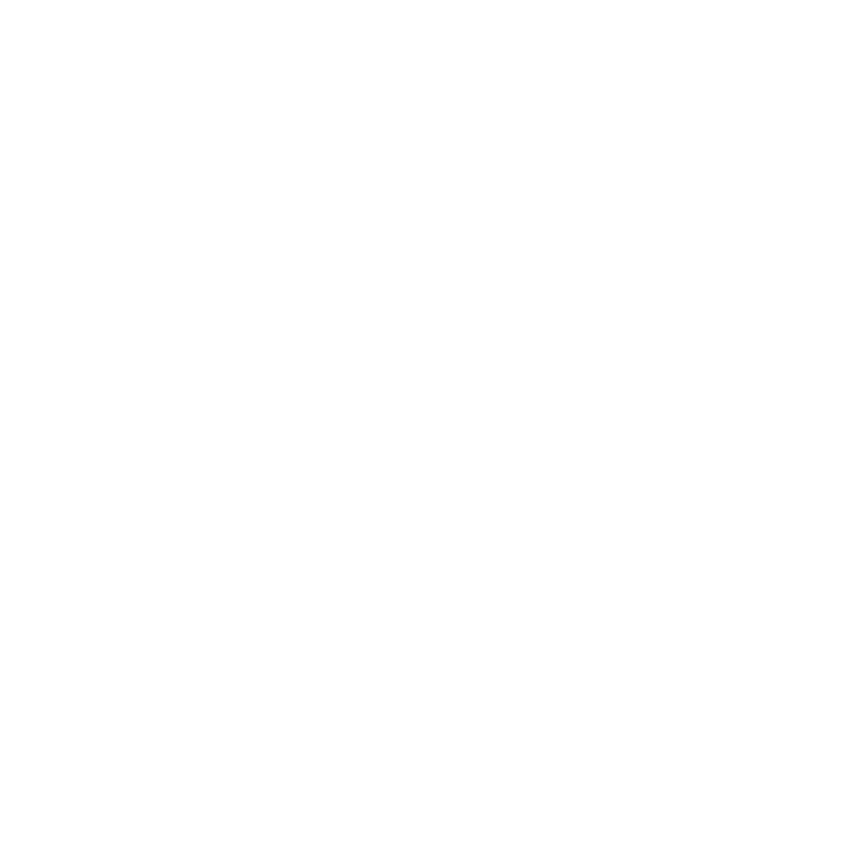

In [15]:
from mpl_toolkits.mplot3d import Axes3D

ishared = S @ ushared
ishared = zscore(ishared)
cmap = cm.get_cmap('gist_ncar')
cmap = cmap(np.linspace(0,0.9,32))
cmap = cmap[np.random.permutation(32),:]
#for j in range(32):
%matplotlib notebook
fig = plt.figure(figsize=(12,12))
use3d=True
if use3d:
    ax=fig.add_subplot(111, projection='3d')
    ax.scatter(out[:,0],out[:,1],ishared,color=cmap[istim,:])    
else:
    ax=fig.add_subplot(111)
    ax.scatter(out[:,0],out[:,1],color=cmap[istim,:],marker='.')    
#ax.set_xlim(-20,20)
#ax.set_ylim(-20,20)
#ax.set_zlim(-2,2)

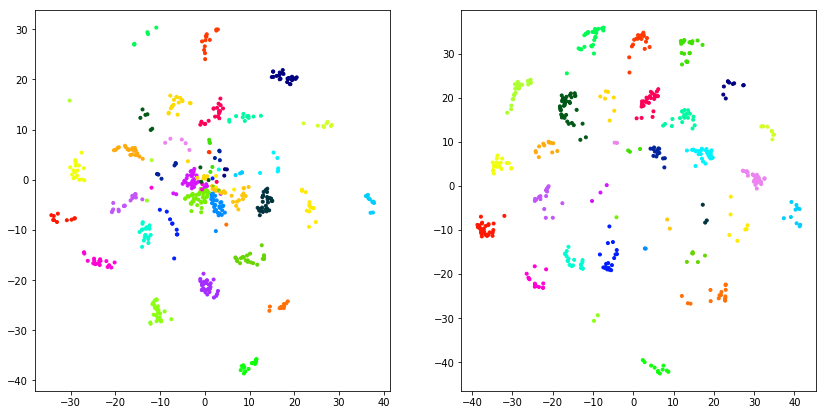

In [29]:

%matplotlib inline
fig = plt.figure(figsize=(14,7))

iinds = ishared.flatten()>1
ax = fig.add_subplot(1,2,1)
ax.scatter(out[iinds,0],out[iinds,1],color=cmap[istim[iinds],:],marker='.')    

iinds = ishared.flatten()<-1
ax = fig.add_subplot(1,2,2)
ax.scatter(out[iinds,0],out[iinds,1],color=cmap[istim[iinds],:],marker='.')    


In [12]:
from sklearn import neighbors
n_neighbors = 1

def ddist(x0,x1,nc):
    d = (dwrap(x0-x1,nc)**2).sum()**0.5
    return d

nc = 150

clf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
                                     #metric=lambda x1,x2: ddist(x1,x2,nc)) 
svc = clf.fit(out[::2,:],istim[::2])

(clf.predict(out[1::2,:])==istim[1::2]).mean()

0.9745762711864406

In [26]:
from sklearn import svm

clf = svm.SVC(degree=3,kernel='rbf')
svc = clf.fit(out[::2,:],istim[::2])

(clf.predict(out[1::2,:])==istim[1::2]).mean()


0.9703389830508474

In [ ]:
masked_target = istim.copy().astype(np.int8)
nstim = istim.size
masked_target[1::2] = -1
reducer = umap.UMAP(n_neighbors=40, min_dist=0.05,n_components=3)
fitter = reducer.fit(resp, y=masked_target)
out = fitter.embedding_

In [ ]:
clf = svm.SVC()
svc = clf.fit(resp[::2,:],istim[::2])

(clf.predict(resp[1::2,:])==istim[1::2]).mean()

In [ ]:
# correlational decoder
resp0 = resp[::2,:]
istim0 = istim[::2]
resp1 = resp[1::2,:]
istim1 = istim[1::2]

iresp = np.zeros((32,resp0.shape[1]),np.float32)
for j in range(32):
    iresp[j,:] = resp0[istim0==j,:].mean(axis=0)
    
cc = (resp1-resp1.mean(axis=1)[:,np.newaxis]) @ (iresp-iresp.mean(axis=1)[:,np.newaxis]).T
cc /= ((resp1-resp1.mean(axis=1)[:,np.newaxis])**2).sum()
cc /= ((iresp-iresp.mean(axis=1)[:,np.newaxis])**2).sum()

(cc.argmax(axis=1)==istim1).mean()


In [ ]:
from sklearn.manifold import SpectralEmbedding
cc = np.corrcoef(resp)
cc = cc-np.diag(np.diag(cc))

out = SpectralEmbedding().fit_transform(cc)

In [ ]:
%matplotlib notebook
fig = plt.figure()
ax=fig.add_subplot(111)#, projection='3d')
ax.scatter(out[:,0],out[:,1],color=cmap[istim,:]) 

In [ ]:
cmap = cm.get_cmap('gist_ncar')
cmap = cmap(np.linspace(0,1,32))

#for j in range(32):
%matplotlib notebook
fig = plt.figure()
ax=fig.add_subplot(111)#, projection='3d'
ax.scatter(out[:,0],out[:,1],color=cmap[istim,:],marker='.')  
#ax.set_xlim(-50,50)
#ax.set_ylim(-50,50)
#ax.set_zlim(-50,50)